In [ ]:
import requests
import time
import pandas as pd
import os

def fetch_papers(api_key, query, output_file, max_papers=500, max_retries=5, verbose=False):
    base_url = "https://api.semanticscholar.org/graph/v1"
    search_url = f"{base_url}/paper/search"
    headers = {
        "Authorization": f"Bearer {api_key}"
    }
    params = {
        "query": query,
        "fields": "paperId,corpusId,url,title,venue,publicationVenue,year,authors,externalIds,abstract,referenceCount,citationCount,influentialCitationCount,isOpenAccess,openAccessPdf,fieldsOfStudy,s2FieldsOfStudy,publicationTypes,publicationDate,journal,citationStyles",
        "limit": 100  # Retrieve 100 papers per request
    }

    papers_data = []
    token = None
    retries = 0

    while len(papers_data) < max_papers:
        if token:
            params["next"] = token  # Pagination token for the next page of results
        response = requests.get(search_url, headers=headers, params=params)

        if response.status_code == 429:
            retry_after = int(response.headers.get("Retry-After", 10))
            if verbose:
                print(f"Rate limit exceeded. Waiting for {retry_after} seconds before retrying...")
            time.sleep(retry_after)
            continue

        if response.status_code == 500:
            retries += 1
            if retries > max_retries:
                print(f"Max retries exceeded for 500 errors. Exiting loop.")
                break
            if verbose:
                print(f"Internal server error. Waiting 10 seconds before retrying... (Attempt {retries}/{max_retries})")
            time.sleep(10)
            continue

        if verbose:
            print(f"Response Status Code: {response.status_code}")
            print(f"Response Content (First 500 chars): {response.text[:500]}")

        if response.status_code != 200:
            print(f"Error fetching data. Status Code: {response.status_code}. Exiting loop.")
            break

        response_data = response.json()

        if 'data' not in response_data or not response_data['data']:
            print("No data found. Exiting loop.")
            break

        # Append paper information to the list
        for paper in response_data.get('data', []):
            paper_info = extract_paper_info(paper, verbose)
            references = fetch_references(api_key, paper.get('paperId'), base_url, max_retries, headers, verbose)
            paper_info["references"] = references
            papers_data.append(paper_info)

            # Stop when 500 papers are retrieved
            if len(papers_data) >= max_papers:
                break

        token = response_data.get('next', None)  # Get the token for the next page of results
        if not token or len(papers_data) >= max_papers:
            if verbose:
                print("No more tokens or max papers reached. Exiting loop.")
            break

        time.sleep(1)

    if papers_data:
        df = pd.DataFrame(papers_data)
        df.to_csv(output_file, index=False, encoding='utf-8', errors='replace')
        print(f"Dataset created successfully: {output_file}")
    else:
        print("No data was added to the dataset. The CSV file was not created.")

def extract_paper_info(paper, verbose=False):
    fields_of_study = paper.get("fieldsOfStudy") or []
    s2_fields_of_study = paper.get("s2FieldsOfStudy") or []
    authors = paper.get("authors", [])
    external_ids = paper.get("externalIds", {})
    open_access_pdf = paper.get("openAccessPdf", {})
    journal_info = paper.get("journal", {}) or {}
    publication_venue = paper.get("publicationVenue", {})

    paper_info = {
        "paperId": paper.get("paperId"),
        "corpusId": paper.get("corpusId"),
        "title": paper.get("title"),
        "year": paper.get("year"),
        "authors": '; '.join([f"{author['name']} (ID: {author['authorId']})" for author in authors]),
        "externalIds": ', '.join([f"{key}: {value}" for key, value in external_ids.items()]),
        "referenceCount": paper.get("referenceCount"),
        "citationCount": paper.get("citationCount"),
        "influentialCitationCount": paper.get("influentialCitationCount"),
        "isOpenAccess": paper.get("isOpenAccess"),
        "fieldsOfStudy": ', '.join(fields_of_study) if isinstance(fields_of_study, list) else '',
        "s2FieldsOfStudy": ', '.join([field.get('category', '') for field in s2_fields_of_study]),
        "publicationTypes": ', '.join(paper.get("publicationTypes") if isinstance(paper.get("publicationTypes"), list) else []),
        "publicationDate": paper.get("publicationDate"),
        "journal": f"{journal_info.get('name', '')}, Volume: {journal_info.get('volume', '')}, Pages: {journal_info.get('pages', '')}" if journal_info else '',
        "citationStyles": paper.get("citationStyles", {}).get("bibtex")
    }
    if verbose:
        print(f"Extracted paper information for: {paper_info['title']}")

    return paper_info

def fetch_references(api_key, paper_id, base_url, max_retries, headers, verbose=False):
    references_url = f"{base_url}/paper/{paper_id}/references"
    retries = 0

    while retries <= max_retries:
        response = requests.get(references_url, headers=headers)

        if response.status_code == 429:
            retry_after = int(response.headers.get("Retry-After", 10))
            if verbose:
                print(f"Rate limit exceeded when fetching references. Waiting for {retry_after} seconds before retrying...")
            time.sleep(retry_after)
            continue

        if response.status_code == 500:
            retries += 1
            if retries > max_retries:
                if verbose:
                    print(f"Max retries exceeded for 500 errors when fetching references. Returning empty list.")
                return []
            if verbose:
                print(f"Internal server error when fetching references. Waiting 10 seconds before retrying... (Attempt {retries}/{max_retries})")
            time.sleep(10)
            continue

        if response.status_code != 200:
            if verbose:
                print(f"Error fetching references. Status Code: {response.status_code}. Returning empty list.")
            return []

        response_data = response.json()
        references = []

        for ref in response_data.get('data', []):
            references.append({
                "referencePaperId": ref.get("citedPaper", {}).get("paperId"),
                "referenceTitle": ref.get("citedPaper", {}).get("title"),
                "referenceAuthors": ', '.join([author.get("name") for author in ref.get("citedPaper", {}).get("authors", [])]),
                "referenceYear": ref.get("citedPaper", {}).get("year"),
                "referenceUrl": ref.get("citedPaper", {}).get("url")
            })

        if verbose:
            print(f"Fetched {len(references)} references for paper ID: {paper_id}")

        return references

    return []

# Example usage
api_key = os.getenv("SEMANTIC_SCHOLAR_API_KEY", "your_default_key_here")
query = "climate change"
output_file = "climate_change_papers_500.csv"

fetch_papers(api_key, query, output_file, max_papers=500, verbose=True)


Response Status Code: 200
Response Content (First 500 chars): {"total": 13490344, "offset": 0, "next": 100, "data": [{"paperId": "c0a737a5f1bcc70c368991c9daec41056894337e", "externalIds": {"DOI": "10.1017/9781009157896", "CorpusId": 259668619}, "corpusId": 259668619, "publicationVenue": null, "url": "https://www.semanticscholar.org/paper/c0a737a5f1bcc70c368991c9daec41056894337e", "title": "Climate Change 2021 \u2013 The Physical Science Basis", "abstract": "The Working Group I contribution to the Sixth Assessment Report of the Intergovernmental Panel on Cl
Extracted paper information for: Climate Change 2021 – The Physical Science Basis
Fetched 0 references for paper ID: c0a737a5f1bcc70c368991c9daec41056894337e
Extracted paper information for: Climate Change 2022 – Impacts, Adaptation and Vulnerability
Fetched 0 references for paper ID: 2f609099c16f84861bb18bdedf784d13d9610cc1
Extracted paper information for: Climate Change 2014 - Synthesis Report
Fetched 0 references for paper ID: d5a

In [ ]:
# Load the dataset to check its structure and identify the 'reference' column for formatting.
import pandas as pd

# Load the dataset
file_path = '/content/climate_change_papers_500.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to identify the 'reference' column
df.head()

,paperId,corpusId,title,year,authors,externalIds,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,s2FieldsOfStudy,publicationTypes,publicationDate,journal,citationStyles,references
0,c0a737a5f1bcc70c368991c9daec41056894337e,259668619,Climate Change 2021 – The Physical Science Basis,2023,Intergovernmental Panel on Climate Change (ID:...,"DOI: 10.1017/9781009157896, CorpusId: 259668619",0,7390,546,True,NaN,"Environmental Science, Physics",NaN,2023-06-29,NaN,"@Inproceedings{Change2023ClimateC2,\n author =...",[]
1,2f609099c16f84861bb18bdedf784d13d9610cc1,261077604,"Climate Change 2022 – Impacts, Adaptation and ...",2023,Dr. Kirstin K. Holsman (ID: 2233104413),"DOI: 10.1017/9781009325844, CorpusId: 261077604",0,3681,137,True,NaN,"Environmental Science, Economics, Political Sc...",NaN,2023-06-22,NaN,"@Inproceedings{Holsman2023ClimateC2,\n author ...",[]
2,d5ab152a21eff7560fae68710c082da76ac86f23,109639809,Climate Change 2014 - Synthesis Report,2015,Jean-Pascal van Ypersele de Strihou (ID: 92605...,"MAG: 1903264570, DOI: 10.59327/ipcc/ar5-978929...",0,4626,452,True,Engineering,"Engineering, Environmental Science",CaseReport,2015-04-30,", Volume: , Pages:","@Inproceedings{Strihou2015ClimateC2,\n author ...",[]
3,10aa6b29ca7077ac5656c9df7f2efc8cab158851,264680779,Climate Change 2013: The Physical Science Basis,2013,Reinhard F. Stocker (ID: 2263092832); Dahe Qin...,"MAG: 2924055038, CorpusId: 264680779",0,13262,907,False,Political Science,"Political Science, Environmental Science, Physics",NaN,NaN,", Volume: , Pages:","@Inproceedings{Stocker2013ClimateC2,\n author ...",[]
4,fd442c078de03450c3ee5def6b76856b6be73181,212790862,Climate Change and Land: an IPCC special repor...,2019,P. Shukla (ID: 13759095); J. Skeg (ID: 1571844...,"MAG: 3004377517, CorpusId: 212790862",2,3041,139,False,Environmental Science,"Environmental Science, Environmental Science, ...",NaN,NaN,", Volume: , Pages:","@Inproceedings{Shukla2019ClimateCA,\n author =...",[{'referencePaperId': '0e11434316b46bed087fc3d...


In [ ]:
# Function to format the references by placing each reference on a new line
def format_references(ref_list):
    # If the references are not an empty list, format them; otherwise, return an empty string
    if pd.notnull(ref_list) and ref_list != '[]':
        return ref_list.replace('},', '},\n')
    else:
        return ''

# Apply the formatting to the 'references' column
df['formatted_references'] = df['references'].apply(format_references)

# Display the first few formatted references
print(df[['title', 'formatted_references']].head())

# Save the formatted dataset as a new CSV file
formatted_file_path = '/content/formatted_climate_change_papers.csv'
df.to_csv(formatted_file_path, index=False)

print(f"Formatted dataset saved to: {formatted_file_path}")


                                               title  \
0   Climate Change 2021 – The Physical Science Basis   
1  Climate Change 2022 – Impacts, Adaptation And ...   
2             Climate Change 2014 - Synthesis Report   
3    Climate Change 2013: The Physical Science Basis   
4  Climate Change And Land: An Ipcc Special Repor...   

                                formatted_references  
0                                                     
1                                                     
2                                                     
3                                                     
4  [{'referencePaperId': '0e11434316b46bed087fc3d...  
Formatted dataset saved to: /content/formatted_climate_change_papers.csv


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   paperId                   500 non-null    object
 1   corpusId                  500 non-null    int64 
 2   title                     500 non-null    object
 3   year                      500 non-null    int64 
 4   authors                   500 non-null    object
 5   externalIds               500 non-null    object
 6   referenceCount            500 non-null    int64 
 7   citationCount             500 non-null    int64 
 8   influentialCitationCount  500 non-null    int64 
 9   isOpenAccess              500 non-null    bool  
 10  fieldsOfStudy             500 non-null    object
 11  s2FieldsOfStudy           500 non-null    object
 12  publicationTypes          298 non-null    object
 13  publicationDate           500 non-null    object
 14  journal                   

In [ ]:
# Inspect the dataset
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   paperId                   500 non-null    object
 1   corpusId                  500 non-null    int64 
 2   title                     500 non-null    object
 3   year                      500 non-null    int64 
 4   authors                   500 non-null    object
 5   externalIds               500 non-null    object
 6   referenceCount            500 non-null    int64 
 7   citationCount             500 non-null    int64 
 8   influentialCitationCount  500 non-null    int64 
 9   isOpenAccess              500 non-null    bool  
 10  fieldsOfStudy             500 non-null    object
 11  s2FieldsOfStudy           500 non-null    object
 12  publicationTypes          298 non-null    object
 13  publicationDate           500 non-null    object
 14  journal                   

## Data Cleaning and Pre-Processing

In [ ]:
# Handle missing data
df['authors'].fillna('Unknown Author', inplace=True)
df['publicationDate'].fillna('0000-00-00', inplace=True)
df['fieldsOfStudy'].fillna('Unknown', inplace=True)
df['journal'].fillna('Unknown', inplace=True)

### Normalizing the Author Name

In [ ]:
def normalize_authors(author_list):
    if pd.notnull(author_list):
        authors = author_list.split('; ')
        normalized_authors = []
        for author in authors:
            name_parts = author.split()
            if len(name_parts) > 1:
                last_name = name_parts[-1]
                first_names = " ".join(name_parts[:-1])
                normalized_authors.append(f"{last_name}, {first_names}")
            else:
                normalized_authors.append(author)  # If name cannot be split, keep as is
        return "; ".join(normalized_authors)
    return author_list

# Apply normalization to the 'authors' column
df['authors'] = df['authors'].apply(normalize_authors)

### Standardize Publication Dates

In [ ]:
# Standardize publication dates to "YYYY-MM-DD" format
df['publicationDate'] = pd.to_datetime(df['publicationDate'], errors='coerce').dt.strftime('%Y-%m-%d')
df['publicationDate'].fillna('0000-00-00', inplace=True)  # Fill invalid dates with placeholder

### Standardize Data Formats

In [ ]:
# Standardize titles to title case
df['title'] = df['title'].str.title()

# Ensure journal names are capitalized
df['journal'] = df['journal'].str.capitalize()

In [ ]:
# Convert the DataFrame to UTF-8 when saving or handling special characters
df.to_csv('/content/final_dataset_500.csv', index=False, encoding='utf-8')


### Metadata Extraction Using Text Mining

In [ ]:
import spacy
import re

# Load the spaCy model for English
nlp = spacy.load("en_core_web_sm")

def extract_metadata(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))  # Extract named entities (e.g., PERSON, ORG)
    return entities

# Example: Apply metadata extraction to titles
df['metadata_entities'] = df['title'].apply(extract_metadata)

### Extract Citation Details Using Regular Expressions

In [ ]:
# Define regex patterns for extracting DOI and journal names
doi_pattern = r'(10.\d{4,9}/[-._;()/:A-Z0-9]+)'
journal_pattern = r'journal of [a-zA-Z\s]+'

def extract_citation_details(text):
    doi_match = re.search(doi_pattern, text, re.IGNORECASE)
    journal_match = re.search(journal_pattern, text, re.IGNORECASE)
    return {'doi': doi_match.group(0) if doi_match else 'N/A',
            'journal': journal_match.group(0) if journal_match else 'N/A'}

# Apply extraction to citationStyles column
df['citation_details'] = df['citationStyles'].apply(extract_citation_details)

In [ ]:
# Save the cleaned and standardized dataset
df.to_csv('/content/cleaned_climate_change_papers.csv', index=False, encoding='utf-8')

# Display a preview of the cleaned data
print(df.head())

                                    paperId   corpusId  \
0  c0a737a5f1bcc70c368991c9daec41056894337e  259668619   
1  2f609099c16f84861bb18bdedf784d13d9610cc1  261077604   
2  d5ab152a21eff7560fae68710c082da76ac86f23  109639809   
3  10aa6b29ca7077ac5656c9df7f2efc8cab158851  264680779   
4  fd442c078de03450c3ee5def6b76856b6be73181  212790862   

                                               title  year  \
0   Climate Change 2021 – The Physical Science Basis  2023   
1  Climate Change 2022 – Impacts, Adaptation And ...  2023   
2             Climate Change 2014 - Synthesis Report  2015   
3    Climate Change 2013: The Physical Science Basis  2013   
4  Climate Change And Land: An Ipcc Special Repor...  2019   

                                             authors  \
0  (ID:, 2191493435), Intergovernmental Panel on ...   
1          (ID:, 2233104413), Dr. Kirstin K. Holsman   
2  (ID:, 92605164), Jean-Pascal van Ypersele de S...   
3  (ID:, 2263092832), Reinhard F. Stocker; (ID:, ...  

## Citation Behavior Analysis

### 3.1 Identify and Analyze Citations

In [ ]:
import re
import pandas as pd

# Load the dataset
#df = pd.read_csv('/content/cleaned_climate_change_papers.csv')

# Define regex patterns for identifying URLs and DOIs
url_pattern = r'https?://[^\s<>"]+|www\.[^\s<>"]+'
doi_pattern = r'(10.\d{4,9}/[-._;()/:A-Z0-9]+)'

# Extract URLs and DOIs from references
def extract_urls_and_dois(ref_text):
    urls = re.findall(url_pattern, ref_text)
    dois = re.findall(doi_pattern, ref_text, re.IGNORECASE)
    return {'urls': urls, 'dois': dois}

df['url_doi_extracted'] = df['references'].apply(extract_urls_and_dois)

# Display the extracted URLs and DOIs
print(df[['title', 'url_doi_extracted']].head())

                                               title         url_doi_extracted
0   Climate Change 2021 – The Physical Science Basis  {'urls': [], 'dois': []}
1  Climate Change 2022 – Impacts, Adaptation And ...  {'urls': [], 'dois': []}
2             Climate Change 2014 - Synthesis Report  {'urls': [], 'dois': []}
3    Climate Change 2013: The Physical Science Basis  {'urls': [], 'dois': []}
4  Climate Change And Land: An Ipcc Special Repor...  {'urls': [], 'dois': []}


Develop Heuristic Criteria for Web Source Identification

In [ ]:
# Function to classify URLs into web sources and scholarly domains
def classify_source(url_list):
    web_sources = []
    scholarly_sources = []

    for url in url_list:
        if '.edu' in url or '.gov' in url or '.ac' in url:  # Scholarly sources
            scholarly_sources.append(url)
        elif '.com' in url or '.org' in url or '.net' in url:  # General web sources
            web_sources.append(url)

    return {'web_sources': web_sources, 'scholarly_sources': scholarly_sources}

# Apply classification to the extracted URLs
df['classified_sources'] = df['url_doi_extracted'].apply(lambda x: classify_source(x['urls']))

# Display results
print(df[['title', 'classified_sources']].head())

                                               title  \
0   Climate Change 2021 – The Physical Science Basis   
1  Climate Change 2022 – Impacts, Adaptation And ...   
2             Climate Change 2014 - Synthesis Report   
3    Climate Change 2013: The Physical Science Basis   
4  Climate Change And Land: An Ipcc Special Repor...   

                             classified_sources  
0  {'web_sources': [], 'scholarly_sources': []}  
1  {'web_sources': [], 'scholarly_sources': []}  
2  {'web_sources': [], 'scholarly_sources': []}  
3  {'web_sources': [], 'scholarly_sources': []}  
4  {'web_sources': [], 'scholarly_sources': []}  


URI Resolution for Web Source Verification

In [ ]:
from urllib.parse import urlparse

# Function to resolve the base domain
def resolve_domain(url):
    try:
        parsed_url = urlparse(url)
        return parsed_url.netloc
    except Exception as e:
        return None

# Apply domain resolution to the web sources
df['resolved_domains'] = df['classified_sources'].apply(lambda x: [resolve_domain(url) for url in x['web_sources']])

# Display resolved domains
print(df[['title', 'resolved_domains']].head())

                                               title resolved_domains
0   Climate Change 2021 – The Physical Science Basis               []
1  Climate Change 2022 – Impacts, Adaptation And ...               []
2             Climate Change 2014 - Synthesis Report               []
3    Climate Change 2013: The Physical Science Basis               []
4  Climate Change And Land: An Ipcc Special Repor...               []


In [ ]:
import sqlite3

# Establish a connection to SQLite database
conn = sqlite3.connect('/content/data/citation_analysis.db')
cursor = conn.cursor()

# Create a table to store citation data
cursor.execute('''
CREATE TABLE IF NOT EXISTS citations (
    paper_id TEXT,
    title TEXT,
    year INTEGER,
    authors TEXT,
    doi TEXT,
    url TEXT,
    source_type TEXT
)
''')

# Insert parsed citation data into the table
for index, row in df.iterrows():
    for url in row['classified_sources']['web_sources']:
        cursor.execute('''
        INSERT INTO citations (paper_id, title, year, authors, doi, url, source_type)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (row['paperId'], row['title'], row['year'], row['authors'], None, url, 'web_source'))

    for url in row['classified_sources']['scholarly_sources']:
        cursor.execute('''
        INSERT INTO citations (paper_id, title, year, authors, doi, url, source_type)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (row['paperId'], row['title'], row['year'], row['authors'], None, url, 'scholarly_source'))

# Commit and close the connection
conn.commit()
conn.close()

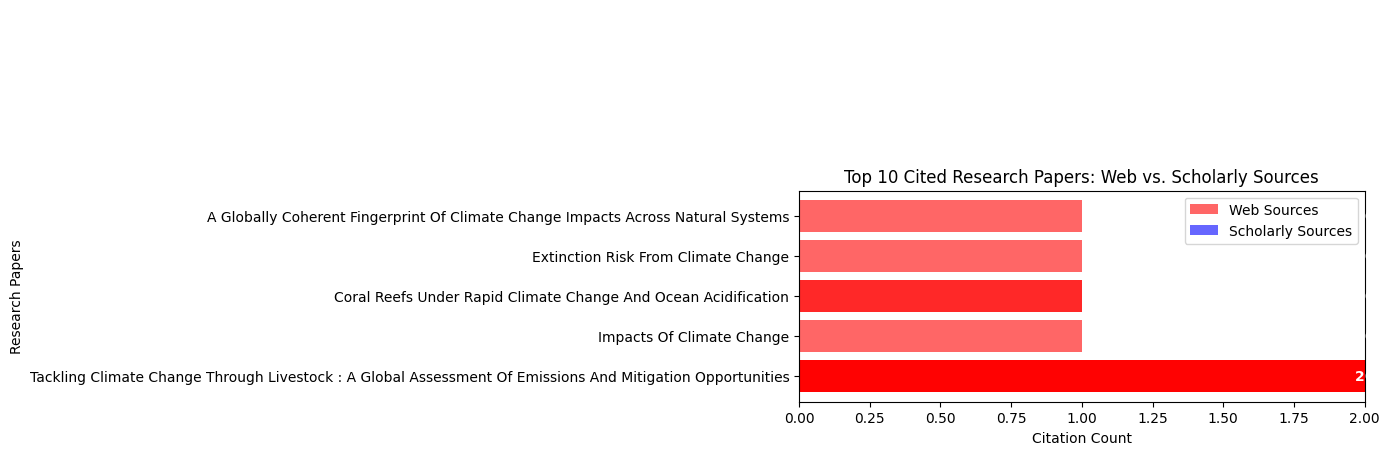

In [ ]:
import matplotlib.pyplot as plt

# Limit the data to top 10 for visualization purposes
df_top = df.nlargest(10, 'web_count')

# Set figure size to accommodate the new layout
plt.figure(figsize=(14, 8))

# Plot horizontal bars with both web and scholarly sources
plt.barh(df_top['title'], df_top['web_count'], label='Web Sources', color='red', alpha=0.6)
plt.barh(df_top['title'], df_top['scholarly_count'], left=df_top['web_count'], label='Scholarly Sources', color='blue', alpha=0.6)

# Add labels and title
plt.xlabel('Citation Count')
plt.ylabel('Research Papers')
plt.title('Top 10 Cited Research Papers: Web vs. Scholarly Sources')

# Display values on the bars
for index, value in enumerate(df_top['web_count']):
    plt.text(value, index, f'{value}', va='center', ha='right', color='white', fontweight='bold')

for index, value in enumerate(df_top['scholarly_count']):
    plt.text(df_top['web_count'].iloc[index] + value, index, f'{value}', va='center', ha='left', color='white', fontweight='bold')

# Add legend
plt.legend()

# Improve layout for readability
plt.tight_layout()

# Display the updated plot
plt.show()

In [ ]:
# Query the number of citations from web and scholarly sources
conn = sqlite3.connect('/content/data/citation_analysis.db')
cursor = conn.cursor()

# Query for the count of web and scholarly sources
cursor.execute('''
SELECT source_type, COUNT(*) as count
FROM citations
GROUP BY source_type
''')

# Fetch and print results
results = cursor.fetchall()
for row in results:
    print(f"Source Type: {row[0]}, Count: {row[1]}")

conn.close()


Source Type: scholarly_source, Count: 15
Source Type: web_source, Count: 90


## Credibility Assessment of Authors

### Extract Author Details and Bibliometric Data

In [ ]:
# Extract relevant columns for author credibility analysis
author_data = df[['authors', 'citationCount', 'influentialCitationCount']]

# Check the dataset structure
print(author_data.head())

                                               authors  citationCount  \
352  (ID:, 40011134), P. Gerber; (ID:, 5741853), H....           2358   
451  (ID:, 40011134), P. Gerber; (ID:, 5741853), H....           2358   
251  (ID:, 40011134), P. Gerber; (ID:, 5741853), H....           2358   
51   (ID:, 40011134), P. Gerber; (ID:, 5741853), H....           2358   
151  (ID:, 40011134), P. Gerber; (ID:, 5741853), H....           2358   

     influentialCitationCount  
352                       398  
451                       398  
251                       398  
51                        398  
151                       398  


### Process and Normalize Author Data

In [ ]:
# Split the authors into individual names (assuming they are separated by commas)
author_data['authors'] = author_data['authors'].fillna('').apply(lambda x: x.split(','))

# Normalize author names (strip whitespace, format "Last Name, First Name")
author_data['authors'] = author_data['authors'].apply(lambda x: [name.strip() for name in x])

# Display the processed authors
print(author_data.head())


                                               authors  citationCount  \
352  [(ID:, 40011134), P. Gerber; (ID:, 5741853), H...           2358   
451  [(ID:, 40011134), P. Gerber; (ID:, 5741853), H...           2358   
251  [(ID:, 40011134), P. Gerber; (ID:, 5741853), H...           2358   
51   [(ID:, 40011134), P. Gerber; (ID:, 5741853), H...           2358   
151  [(ID:, 40011134), P. Gerber; (ID:, 5741853), H...           2358   

     influentialCitationCount  
352                       398  
451                       398  
251                       398  
51                        398  
151                       398  


<ipython-input-61-bf87f355c29a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data['authors'] = author_data['authors'].fillna('').apply(lambda x: x.split(','))
<ipython-input-61-bf87f355c29a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data['authors'] = author_data['authors'].apply(lambda x: [name.strip() for name in x])


### Calculate Bibliometric Indicators

In [ ]:
# Explode the authors list into individual rows
author_data_exploded = author_data.explode('authors')

# Group by author to get total citation counts
author_citation_counts = author_data_exploded.groupby('authors').agg({
    'citationCount': 'sum',
    'influentialCitationCount': 'sum'
}).reset_index()

# Display the aggregated citation counts
print(author_citation_counts.head())

       authors  citationCount  influentialCitationCount
0                        9245                       975
1         (ID:        1641448                     90324
2  10 F.; (ID:           2270                        25
3   100599204)           1365                        15
4   100858799)           1365                        15


### Perform Co-authorship Network Analysis

In [ ]:
# Set a threshold for filtering authors by citation count
citation_threshold = 10  # Adjust this threshold based on the dataset

# Filter the author data for those above the citation threshold
filtered_authors = author_citation_counts[author_citation_counts['citationCount'] > citation_threshold]

# Filter the original author data to only include those authors
filtered_author_data = author_data_exploded[author_data_exploded['authors'].isin(filtered_authors['authors'])]

# Display the filtered dataset
print(filtered_author_data.head())


                authors  citationCount  influentialCitationCount
352                (ID:           2358                       398
352           40011134)           2358                       398
352     P. Gerber; (ID:           2358                       398
352            5741853)           2358                       398
352  H. Steinfeld; (ID:           2358                       398


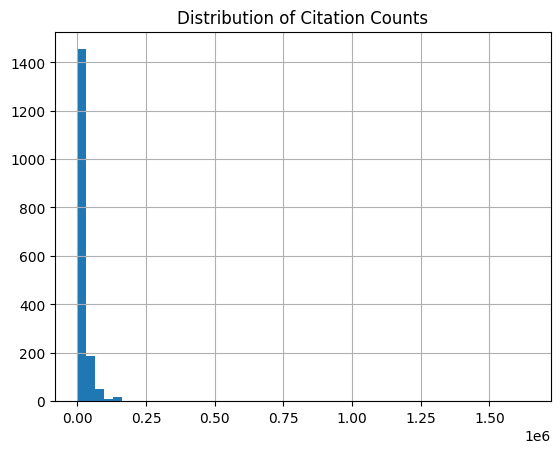

In [ ]:
# Check the distribution of citation counts
author_citation_counts['citationCount'].hist(bins=50)
plt.title("Distribution of Citation Counts")
plt.show()

In [ ]:
# Set a threshold based on the 90th percentile of citation counts
citation_threshold = author_citation_counts['citationCount'].quantile(0.90)

# Filter authors based on this threshold
filtered_authors = author_citation_counts[author_citation_counts['citationCount'] > citation_threshold]

# Print the number of authors after applying the threshold
filtered_authors.shape[0]

172

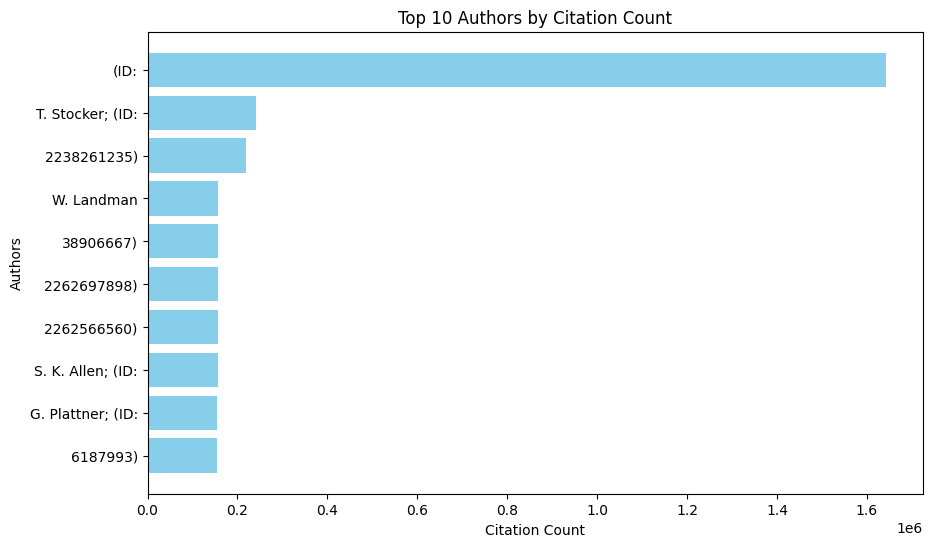

In [ ]:
# Let's create a bar chart for the Top 10 authors by citation count.
import matplotlib.pyplot as plt

# Select the top 10 authors by citation count from the filtered dataset
top_authors = filtered_authors.sort_values(by='citationCount', ascending=False).head(10)

# Plotting the top authors by citation count
plt.figure(figsize=(10,6))
plt.barh(top_authors['authors'], top_authors['citationCount'], color='skyblue')
plt.xlabel('Citation Count')
plt.ylabel('Authors')
plt.title('Top 10 Authors by Citation Count')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest at the top
plt.show()

In [ ]:
print(filtered_authors.columns)

Index(['authors', 'citationCount', 'influentialCitationCount'], dtype='object')


<ipython-input-81-ca9946dbe1f8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='citationCount', y='authors', data=top_authors_by_citations, palette='Blues_d')


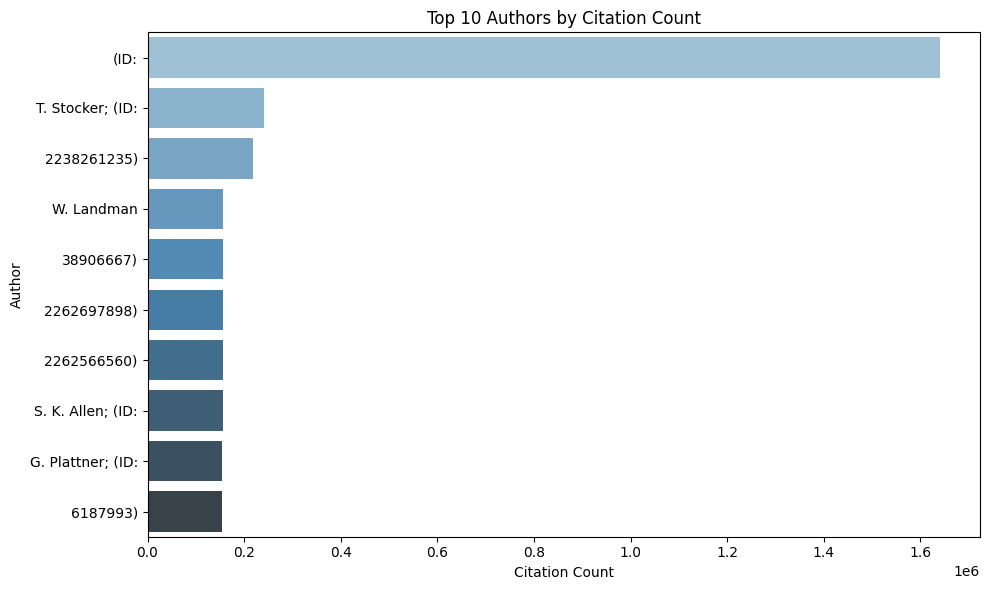

In [ ]:
# Sort by citationCount and select the top 10 authors
top_authors_by_citations = filtered_authors.sort_values(by='citationCount', ascending=False).head(10)

# Bar chart of the top 10 authors by citation count
plt.figure(figsize=(10, 6))
sns.barplot(x='citationCount', y='authors', data=top_authors_by_citations, palette='Blues_d')
plt.title('Top 10 Authors by Citation Count')
plt.xlabel('Citation Count')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

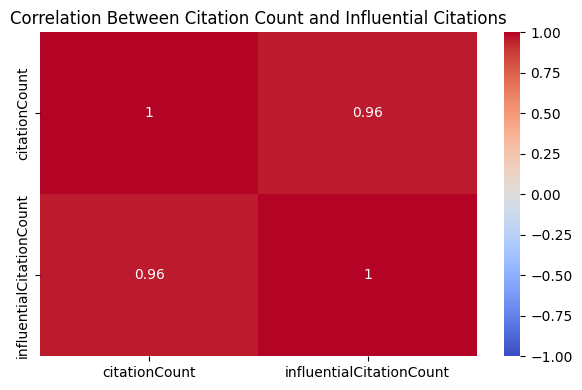

In [ ]:
# Correlation heatmap between citationCount and influentialCitationCount
plt.figure(figsize=(6, 4))
corr = filtered_authors[['citationCount', 'influentialCitationCount']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Citation Count and Influential Citations')
plt.tight_layout()
plt.show()

<ipython-input-85-ca9946dbe1f8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='citationCount', y='authors', data=top_authors_by_citations, palette='Blues_d')


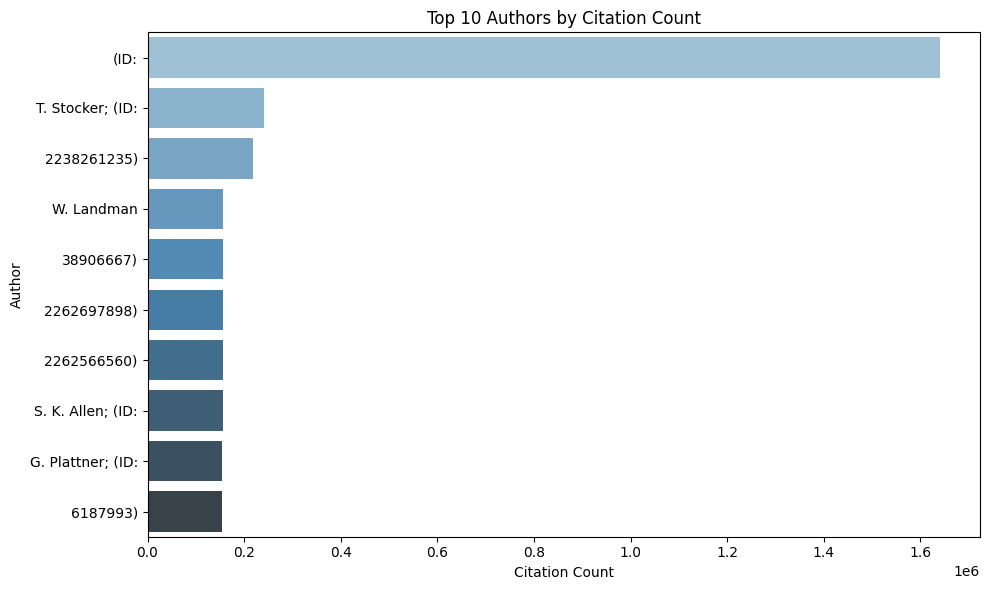

In [ ]:
# Sort by citationCount and select the top 10 authors
top_authors_by_citations = filtered_authors.sort_values(by='citationCount', ascending=False).head(10)

# Bar chart of the top 10 authors by citation count
plt.figure(figsize=(10, 6))
sns.barplot(x='citationCount', y='authors', data=top_authors_by_citations, palette='Blues_d')
plt.title('Top 10 Authors by Citation Count')
plt.xlabel('Citation Count')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

5. Trustworthiness Score Calculation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Define the weights for each metric
weights = {
    'citationCount': 0.4,  # weight for citation count
    'influentialCitationCount': 0.3,  # weight for influential citations
    'author_credibility': 0.3  # weight for author credibility (e.g., h-index or similar)
}

# Create a sample credibility metric (assuming it's not present in df)
# For this example, we can use citationCount as a proxy for author credibility if no other metric is available
df['author_credibility'] = df['citationCount'] / df['citationCount'].max()  # Normalized credibility as a proxy

In [ ]:
# Initialize a MinMaxScaler to scale between 0 and 1
scaler = MinMaxScaler()

# Normalize the relevant metrics
df[['normalized_citationCount', 'normalized_influentialCitationCount', 'normalized_author_credibility']] = scaler.fit_transform(
    df[['citationCount', 'influentialCitationCount', 'author_credibility']])

# Display the normalized values to verify
df[['normalized_citationCount', 'normalized_influentialCitationCount', 'normalized_author_credibility']].head()

,normalized_citationCount,normalized_influentialCitationCount,normalized_author_credibility
352,0.07065,0.279774,0.07065
451,0.07065,0.279774,0.07065
251,0.07065,0.279774,0.07065
51,0.07065,0.279774,0.07065
151,0.07065,0.279774,0.07065


In [ ]:
# Implement the trustworthiness scoring algorithm
df['trustworthiness_score'] = (
    weights['citationCount'] * df['normalized_citationCount'] +
    weights['influentialCitationCount'] * df['normalized_influentialCitationCount'] +
    weights['author_credibility'] * df['normalized_author_credibility']
)

# Display the top entries sorted by trustworthiness score
df[['authors', 'citationCount', 'influentialCitationCount', 'trustworthiness_score']].sort_values(by='trustworthiness_score', ascending=False).head(10)

,authors,citationCount,influentialCitationCount,trustworthiness_score
207,"(ID:, 38906667), W. Landman",31350,1420,1.000000
407,"(ID:, 38906667), W. Landman",31350,1420,1.000000
7,"(ID:, 38906667), W. Landman",31350,1420,1.000000
107,"(ID:, 38906667), W. Landman",31350,1420,1.000000
307,"(ID:, 38906667), W. Landman",31350,1420,1.000000
213,"(ID:, 2530017), J. Seinfeld; (ID:, 5103014), S...",13163,1420,0.591906
13,"(ID:, 2530017), J. Seinfeld; (ID:, 5103014), S...",13163,1420,0.591906
113,"(ID:, 2530017), J. Seinfeld; (ID:, 5103014), S...",13163,1420,0.591906
313,"(ID:, 2530017), J. Seinfeld; (ID:, 5103014), S...",13163,1420,0.591906
413,"(ID:, 2530017), J. Seinfeld; (ID:, 5103014), S...",13163,1420,0.591906


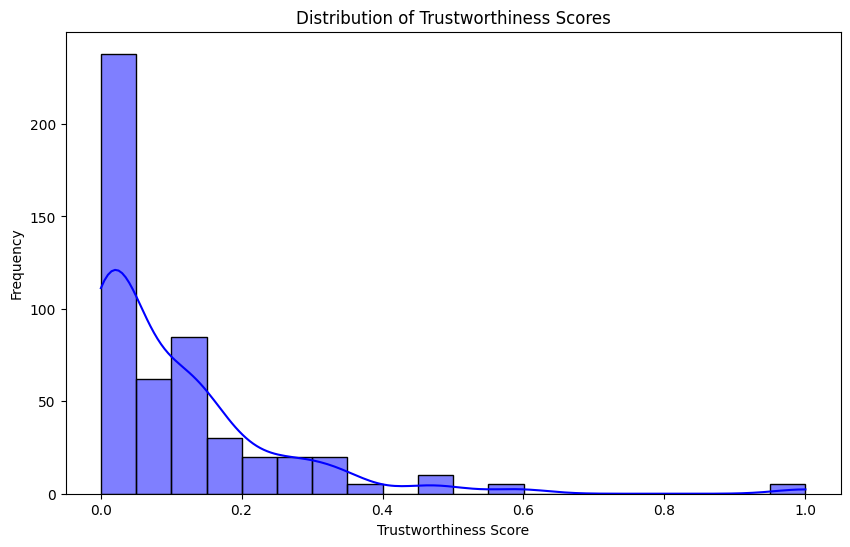

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the trustworthiness scores
plt.figure(figsize=(10, 6))
sns.histplot(df['trustworthiness_score'], bins=20, kde=True, color='blue')
plt.title('Distribution of Trustworthiness Scores')
plt.xlabel('Trustworthiness Score')
plt.ylabel('Frequency')
plt.show()

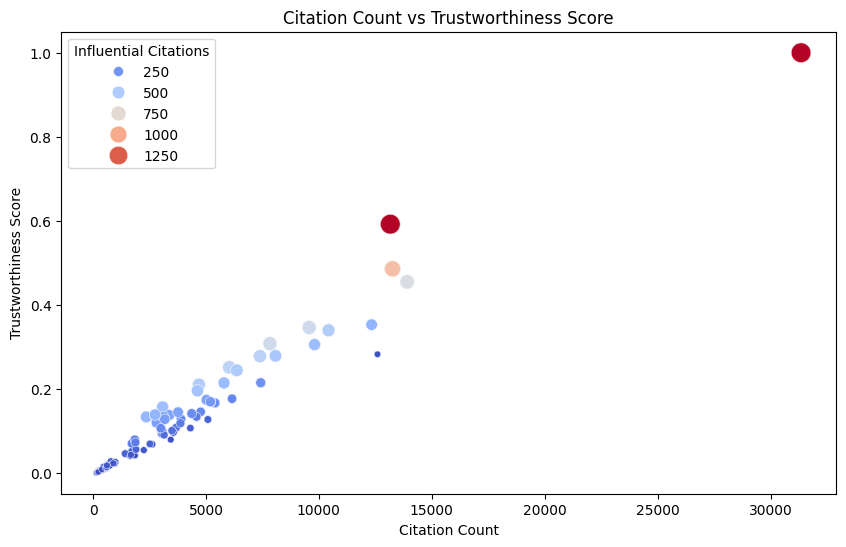

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='citationCount', y='trustworthiness_score', data=df, hue='influentialCitationCount', palette='coolwarm', size='influentialCitationCount', sizes=(20, 200))
plt.title('Citation Count vs Trustworthiness Score')
plt.xlabel('Citation Count')
plt.ylabel('Trustworthiness Score')
plt.legend(title='Influential Citations')
plt.show()

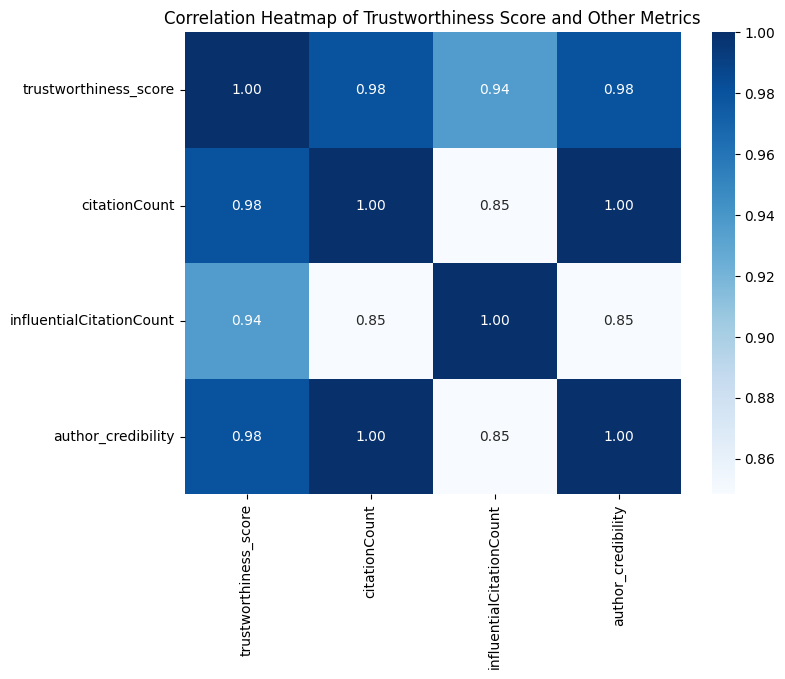

In [ ]:
# Correlation matrix
correlation_matrix = df[['trustworthiness_score', 'citationCount', 'influentialCitationCount', 'author_credibility']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap of Trustworthiness Score and Other Metrics')
plt.show()

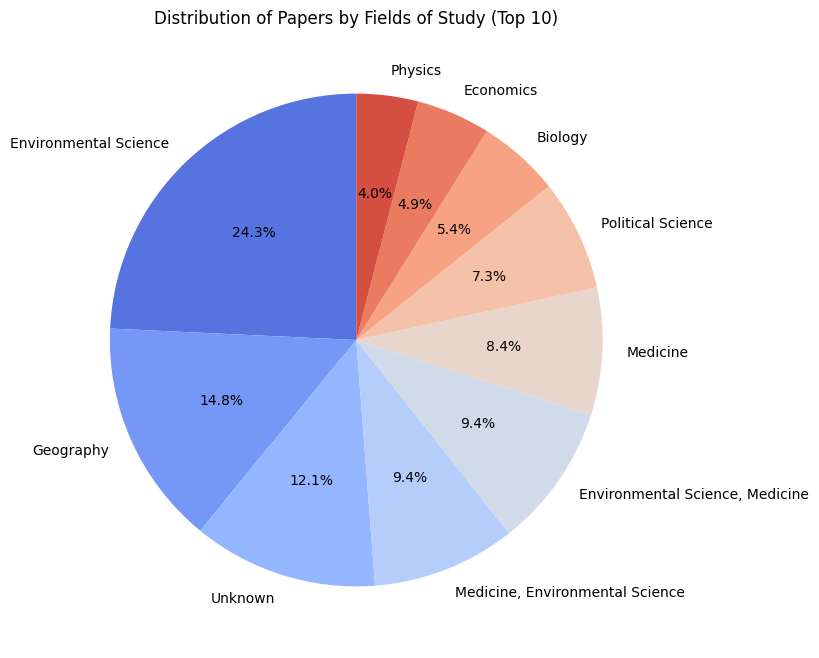

In [ ]:
# Distribution of papers by fields of study
fields_distribution = df['fieldsOfStudy'].value_counts().head(10)

# Plotting pie chart
plt.figure(figsize=(8, 8))
fields_distribution.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm', n_colors=10))
plt.title('Distribution of Papers by Fields of Study (Top 10)')
plt.ylabel('')
plt.show()

<ipython-input-97-eb99810132b1>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['publicationDate'] = pd.to_datetime(df['publicationDate'], errors='coerce')


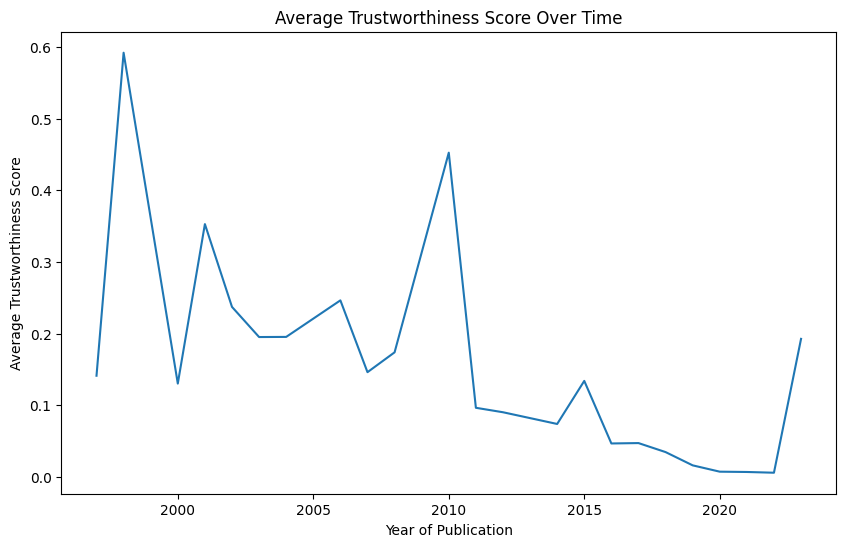

In [ ]:
# Convert publication date to datetime if not already done
df['publicationDate'] = pd.to_datetime(df['publicationDate'], errors='coerce')

# Aggregate trustworthiness score by year of publication
df_grouped_by_year = df.groupby(df['publicationDate'].dt.year)['trustworthiness_score'].mean().dropna()

# Plotting the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=df_grouped_by_year.index, y=df_grouped_by_year.values)
plt.title('Average Trustworthiness Score Over Time')
plt.xlabel('Year of Publication')
plt.ylabel('Average Trustworthiness Score')
plt.show()

### Websource Citation

In [ ]:
import pandas as pd
import re
from urllib.parse import urlparse

# Assuming 'df' is your DataFrame containing a 'references' column
def extract_urls(text):
    # Regex pattern to match URLs
    url_pattern = r'https?://[^\s]+'
    return re.findall(url_pattern, text)

# Apply the extraction function to the references column
df['extracted_urls'] = df['references'].apply(extract_urls)

In [ ]:
def extract_domain(urls):
    domains = []
    for url in urls:
        domain = urlparse(url).netloc  # Extract the domain
        if domain:
            domains.append(domain)
    return domains

# Apply the domain extraction function
df['domains'] = df['extracted_urls'].apply(extract_domain)

In [ ]:
# Explode the list of domains into individual rows for easier counting
df_exploded = df.explode('domains')

# Count the occurrences of each domain
domain_counts = df_exploded['domains'].value_counts().reset_index()
domain_counts.columns = ['domain', 'count']

# Display the top 10 most cited domains
print(domain_counts.head(10))

               domain  count
0           v-c-s.org      5
1  data.worldbank.org      5
2        www.dairyuk.      5
3      www.ucsusa.org      5
4      www.nature.com      5
5               doi',      5


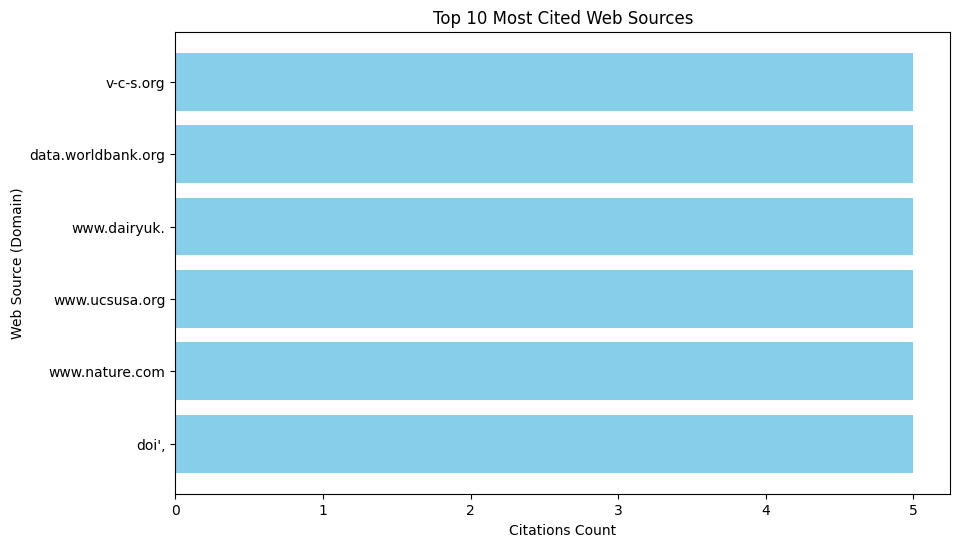

In [ ]:
import matplotlib.pyplot as plt

# Select the top 10 most cited domains
top_domains = domain_counts.head(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_domains['domain'], top_domains['count'], color='skyblue')
plt.xlabel('Citations Count')
plt.ylabel('Web Source (Domain)')
plt.title('Top 10 Most Cited Web Sources')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
plt.show()

Page Rank

In [ ]:
pip install networkx

In [ ]:
import pandas as pd
import networkx as nx
from urllib.parse import urlparse
import re

# Assuming 'df' contains the references column with extracted URLs.
def extract_urls(text):
    url_pattern = r'https?://[^\s]+'
    return re.findall(url_pattern, text)

def extract_domain(urls):
    domains = []
    for url in urls:
        domain = urlparse(url).netloc
        if domain:
            domains.append(domain)
    return domains

# Extract URLs and domains
df['extracted_urls'] = df['references'].apply(extract_urls)
df['domains'] = df['extracted_urls'].apply(extract_domain)

# Create a directed graph from the domain citation relationships
G = nx.DiGraph()

# For simplicity, assume that if a paper cites multiple web sources,
# each web source "cites" the others (since citation is indirect).
for idx, row in df.iterrows():
    domains = row['domains']
    if len(domains) > 1:
        for i in range(len(domains)):
            for j in range(len(domains)):
                if i != j:
                    G.add_edge(domains[i], domains[j])

print(f"Graph created with {len(G.nodes)} nodes and {len(G.edges)} edges.")


Graph created with 3 nodes and 6 edges.


In [ ]:
# Apply the PageRank algorithm
pagerank_scores = nx.pagerank(G)

# Convert the PageRank scores to a DataFrame for easier analysis
pagerank_df = pd.DataFrame(list(pagerank_scores.items()), columns=['domain', 'pagerank_score'])

# Sort by the PageRank score
pagerank_df = pagerank_df.sort_values(by='pagerank_score', ascending=False)

# Display the top 10 web sources by PageRank score
print(pagerank_df.head(10))

               domain  pagerank_score
0           v-c-s.org        0.333333
1  data.worldbank.org        0.333333
2        www.dairyuk.        0.333333


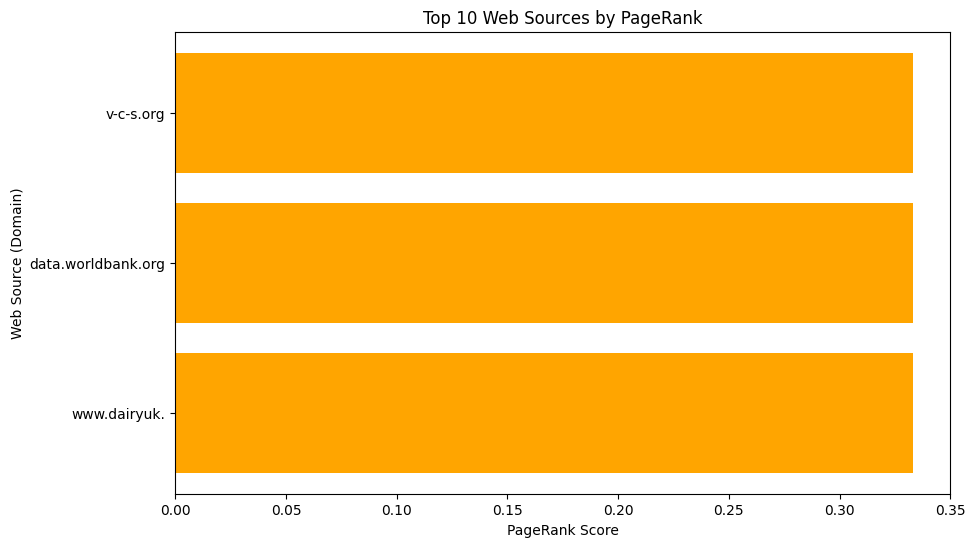

In [ ]:
import matplotlib.pyplot as plt

# Select the top 10 most important domains by PageRank score
top_pagerank = pagerank_df.head(10)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_pagerank['domain'], top_pagerank['pagerank_score'], color='orange')
plt.xlabel('PageRank Score')
plt.ylabel('Web Source (Domain)')
plt.title('Top 10 Web Sources by PageRank')
plt.gca().invert_yaxis()
plt.show()

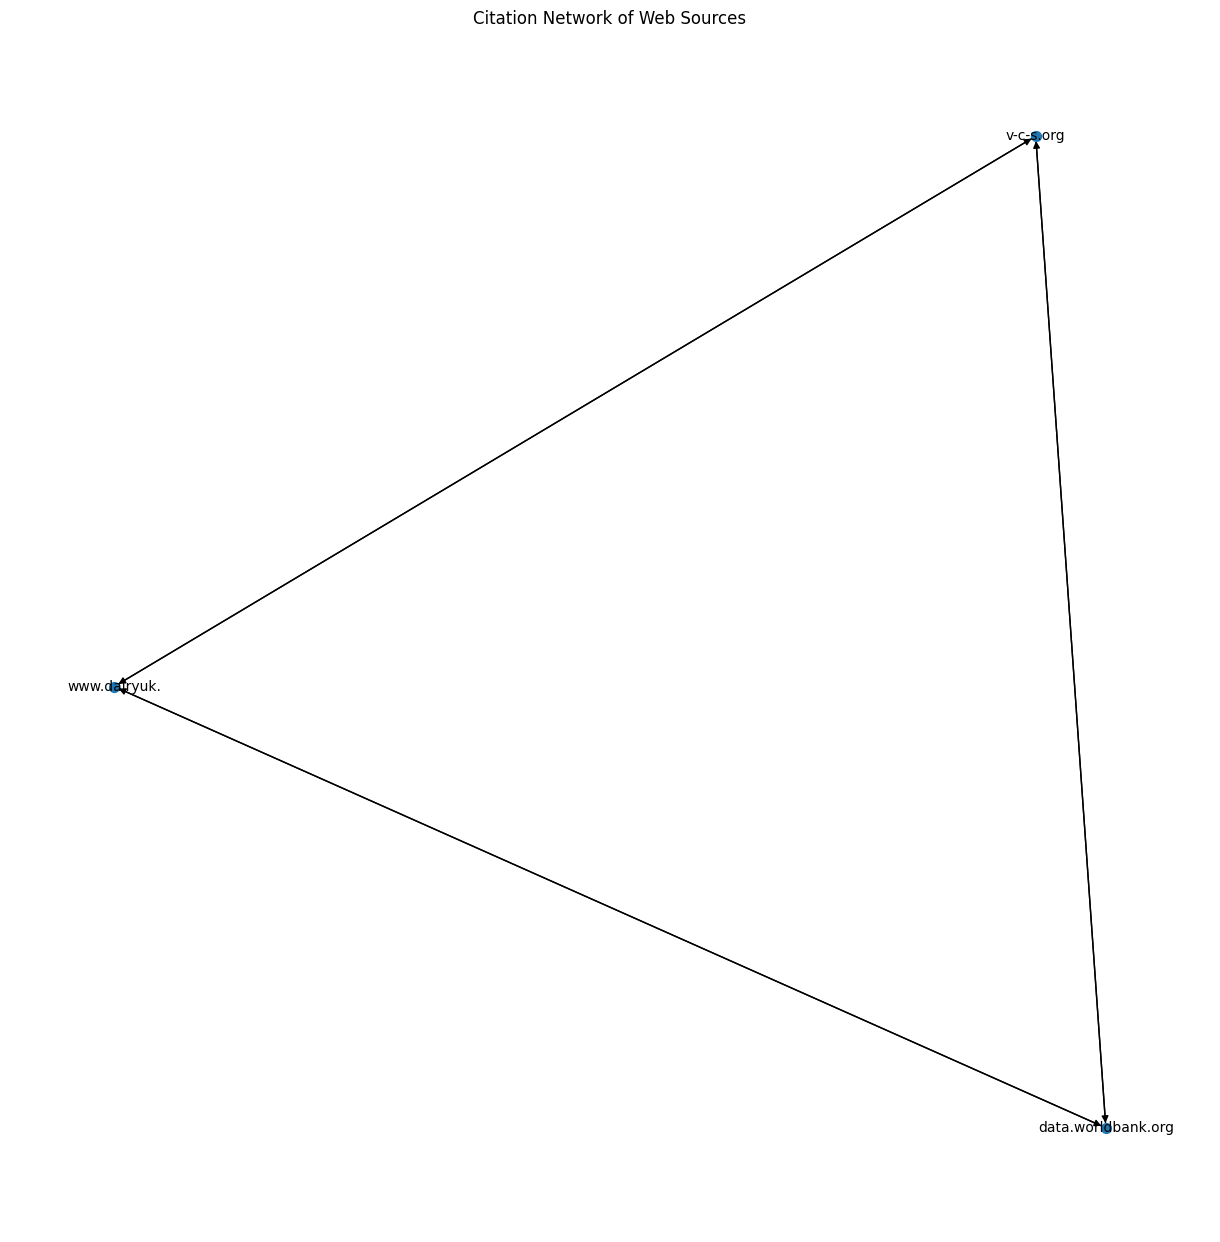

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # Positions the nodes
nx.draw(G, pos, with_labels=True, node_size=50, font_size=10)
plt.title('Citation Network of Web Sources')
plt.show()